In [36]:
import warnings

warnings.filterwarnings(action='ignore')

import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from torch import nn
from torch.utils.data import random_split, DataLoader
from torchvision.io import read_image
from torchvision.transforms.functional import resize
from forest_cover_change_detection.dataloaders.change import ChangeDetectionDataset
from forest_cover_change_detection.models.fc_ef import FCFE
from forest_cover_change_detection.trainer.train import Compile
from forest_cover_change_detection.metrics.accuracy import *

### Loading Data

In [16]:
data_set = ChangeDetectionDataset('../../data/annotated',
                                  '../../data/patch_train.csv',
                                  concat=True,
                                  patched=True
                                  )

In [17]:
len(data_set)

1203

torch.Size([6, 256, 256]) torch.Size([256, 256])


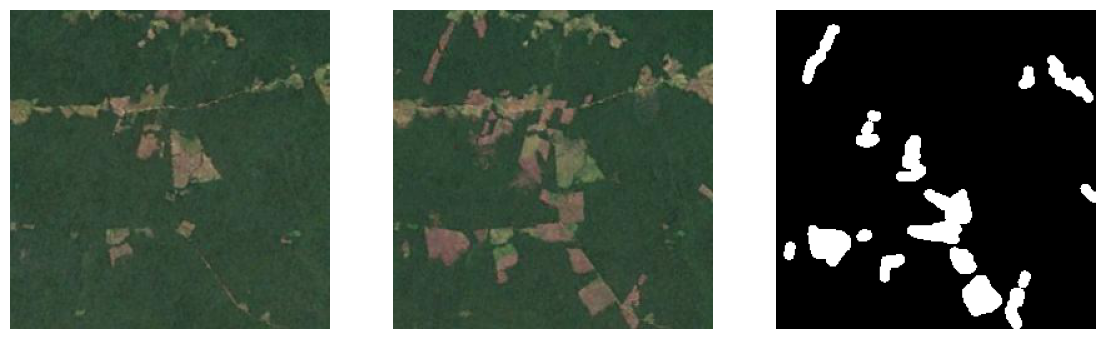

In [21]:
img, label = data_set[np.random.randint(0, data_set.__len__())]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 8), dpi=100)
axes = axes.ravel()

axes[0].imshow(img[:3, ::].permute(1, 2, 0).numpy())
axes[1].imshow(img[3:, ::].permute(1, 2, 0).numpy())
axes[2].imshow(label.numpy(), cmap='gray')

axes[0].axis(False)
axes[1].axis(False)
axes[2].axis(False)

print(img.shape, label.shape)

In [22]:
train_size = int(len(data_set) * 0.8)
test_size = len(data_set) - train_size

train_dataset, test_dataset = random_split(data_set, (train_size, test_size))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

len(train_dataloader), len(test_dataloader)

(31, 8)

### Modeling

In [23]:
model = FCFE(6, 3, classes=2)

In [24]:
optimizer = AdamW(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, cooldown=10)
# scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=50)

compiled = Compile(model,
                   optimizer,
                   lr_scheduler=scheduler
                   )

In [8]:
compiled.summary((6, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             880
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
           Dropout-4         [-1, 16, 256, 256]               0
            Conv2d-5         [-1, 16, 256, 256]           2,320
       BatchNorm2d-6         [-1, 16, 256, 256]              32
              ReLU-7         [-1, 16, 256, 256]               0
           Dropout-8         [-1, 16, 256, 256]               0
         MaxPool2d-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 32, 128, 128]           4,640
      BatchNorm2d-11         [-1, 32, 128, 128]              64
             ReLU-12         [-1, 32, 128, 128]               0
          Dropout-13         [-1, 32, 128, 128]               0
           Conv2d-14         [-1, 32, 1


(dot.exe:13628): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


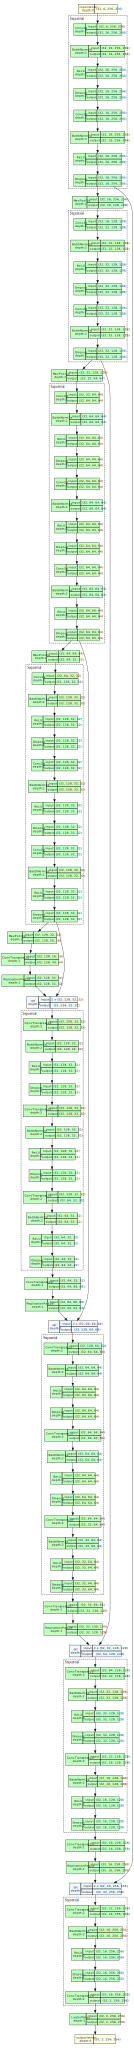

In [9]:
compiled.visual_graph((32, 6, 256, 256))

In [25]:
w = torch.load('../../data/annotated/class_weight.pt')
w

tensor([0.0962, 1.9038], device='cuda:0')

In [26]:
results = compiled.train(train_dataloader,
                         nn.NLLLoss(w),
                         100,
                         test_dataloader)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0/100
train loss: 0.5616909813496375
val loss: 0.6342252716422081
Epoch: 1/100
train loss: 0.4122194263242906
val loss: 0.4843870475888252
Epoch: 2/100
train loss: 0.39789962480145113
val loss: 0.4520568996667862
Epoch: 3/100
train loss: 0.3820097917510617
val loss: 0.4601866416633129
Epoch: 4/100
train loss: 0.37171691271566576
val loss: 0.4664449095726013
Epoch: 5/100


KeyboardInterrupt: 

In [37]:
# restore best checkpoint
state = torch.load("../../checkpoints/fcfe/best v1/best_model.pth")
model.load_state_dict(state['model_state_dict'])
model = model.cuda()

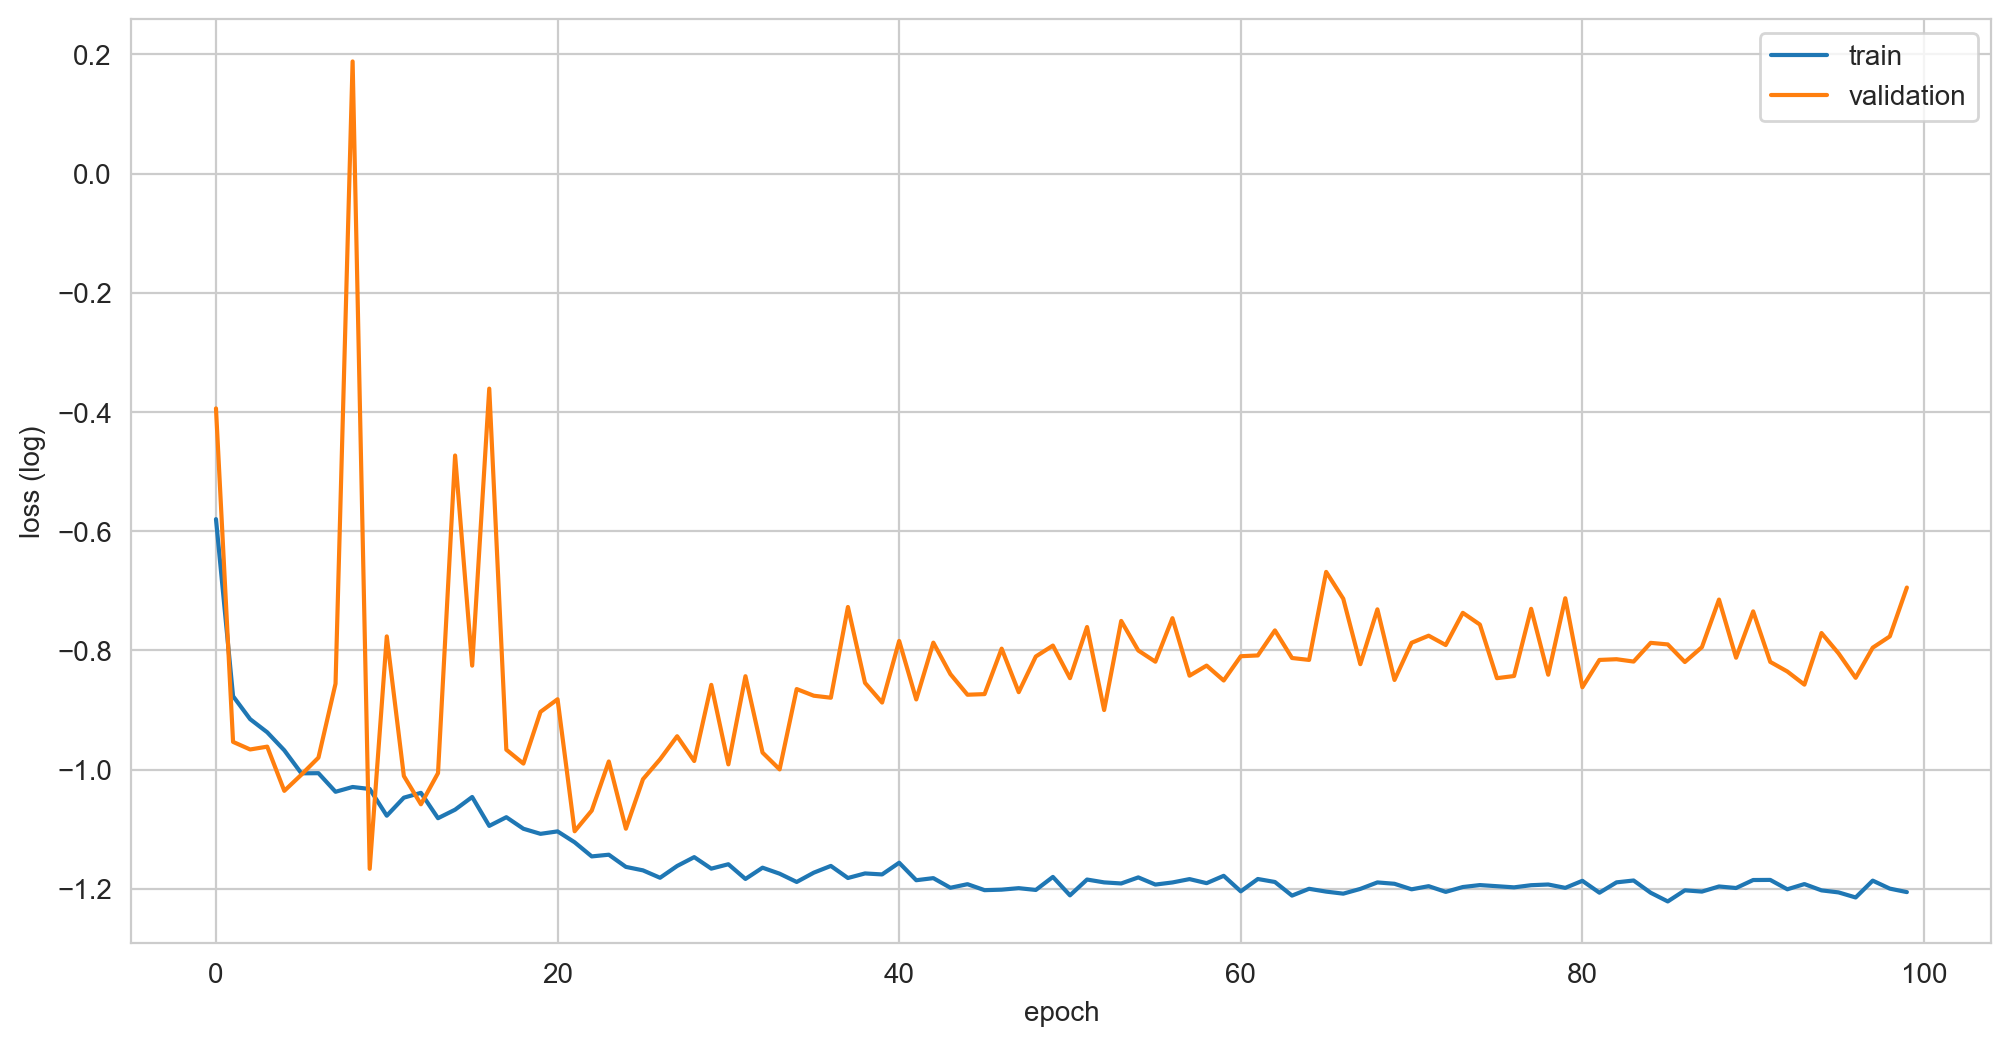

In [13]:
plt.figure(figsize=(12, 6), dpi=200)
sns.lineplot(x=results['epoch'], y=results['train loss'], label='train')
sns.lineplot(x=results['epoch'], y=results['val loss'], label='validation')
plt.ylabel('loss (log)')
plt.show()

In [38]:
df = pd.read_csv('../../data/annotated/test.csv')

In [39]:
acc_test = []
change_acc = []
no_change_acc = []
p = []
r = []
d = []
k = []
metrics = pd.DataFrame()

for i, row in tqdm(df.iterrows()):
    img, gt = (read_image(f'../../data/annotated/{row.dir}/{row.img_1}'),
               read_image(f'../../data/annotated/{row.dir}/{row.img_2}')), read_image(
        f'../../data/annotated/{row.label}')

    img1 = resize(img[0], size=[256, 256]) / 255.0
    img2 = resize(img[1], size=[256, 256]) / 255.0
    gt = resize(gt, size=[256, 256]).squeeze(0) / 255.0

    with torch.no_grad():
        model.eval()
        logits = model(torch.cat((img1, img2), dim=0).unsqueeze(0).to('cuda'))[0].cpu()
        pred = torch.argmax(torch.sigmoid(logits), dim=0)

    class_acc = class_accuracy(gt, logits)

    acc_test.append(pixel_accuracy(gt, pred).numpy().tolist())
    p.append(precision(gt, pred).numpy().tolist())
    r.append(recall(gt, pred).numpy().tolist())
    d.append(dice(gt, pred).numpy().tolist())
    k.append(kappa(gt, pred).numpy().tolist())
    no_change_acc.append(class_acc[0])
    change_acc.append(class_acc[1])

metrics['overall accuracy'] = acc_test
metrics['change accuracy'] = change_acc
metrics['no change accuracy'] = no_change_acc
metrics['precision'] = p
metrics['recall'] = r
metrics['dice'] = d
metrics['kappa'] = k

0it [00:00, ?it/s]

In [40]:
metrics.mean()

overall accuracy      0.958068
change accuracy       0.161850
no change accuracy    0.994817
precision             0.411290
recall                0.142265
dice                  0.248437
kappa                 0.176444
dtype: float64

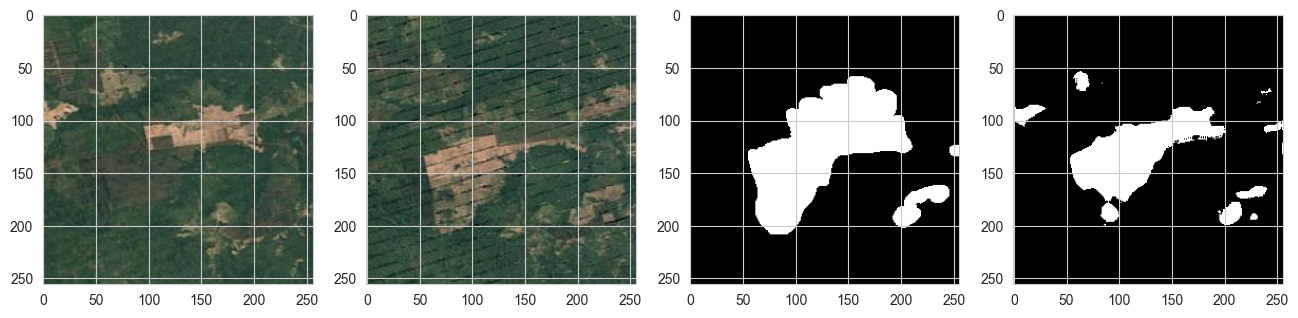

In [48]:
img, gt = test_dataset[np.random.randint(0, len(test_dataset))]

with torch.no_grad():
    model.eval()
    logits = model(img.unsqueeze(0).to('cuda'))[0].cpu()
    pred = torch.argmax(torch.sigmoid(logits), dim=0)

plt.figure(figsize=(16, 10))
plt.subplot(1, 4, 1)
plt.imshow(img[:3, ::].permute(1, 2, 0), cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(gt, cmap='gray')
plt.subplot(1, 4, 2)
plt.imshow(img[3:, ::].permute(1, 2, 0), cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(pred, cmap='gray')